In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Load Data
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')



2025-05-10 15:27:52.275627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746890872.529036      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746890872.617836      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

# Data Preprocessing
X = train_df.drop('label', axis=1).values.reshape(-1, 28, 28, 1) / 255.0
y = to_categorical(train_df['label'].values, num_classes=10)
X_test = test_df.values.reshape(-1, 28, 28, 1) / 255.0

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-10 15:28:11.865546: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# Train Model
start_time = time.time()
history = model.fit(X_train, y_train, epochs=15, batch_size=64,
                    validation_data=(X_val, y_val), verbose=2)
training_time = time.time() - start_time
print("Training Time: ",training_time)

Epoch 1/15
525/525 - 17s - 33ms/step - accuracy: 0.8735 - loss: 0.4007 - val_accuracy: 0.9701 - val_loss: 0.1047
Epoch 2/15
525/525 - 14s - 27ms/step - accuracy: 0.9582 - loss: 0.1390 - val_accuracy: 0.9795 - val_loss: 0.0637
Epoch 3/15
525/525 - 14s - 27ms/step - accuracy: 0.9687 - loss: 0.1000 - val_accuracy: 0.9836 - val_loss: 0.0511
Epoch 4/15
525/525 - 14s - 28ms/step - accuracy: 0.9740 - loss: 0.0840 - val_accuracy: 0.9855 - val_loss: 0.0459
Epoch 5/15
525/525 - 14s - 26ms/step - accuracy: 0.9786 - loss: 0.0709 - val_accuracy: 0.9881 - val_loss: 0.0385
Epoch 6/15
525/525 - 21s - 40ms/step - accuracy: 0.9798 - loss: 0.0640 - val_accuracy: 0.9870 - val_loss: 0.0382
Epoch 7/15
525/525 - 14s - 26ms/step - accuracy: 0.9823 - loss: 0.0576 - val_accuracy: 0.9892 - val_loss: 0.0340
Epoch 8/15
525/525 - 14s - 27ms/step - accuracy: 0.9830 - loss: 0.0553 - val_accuracy: 0.9899 - val_loss: 0.0306
Epoch 9/15
525/525 - 14s - 26ms/step - accuracy: 0.9833 - loss: 0.0511 - val_accuracy: 0.9895 - 

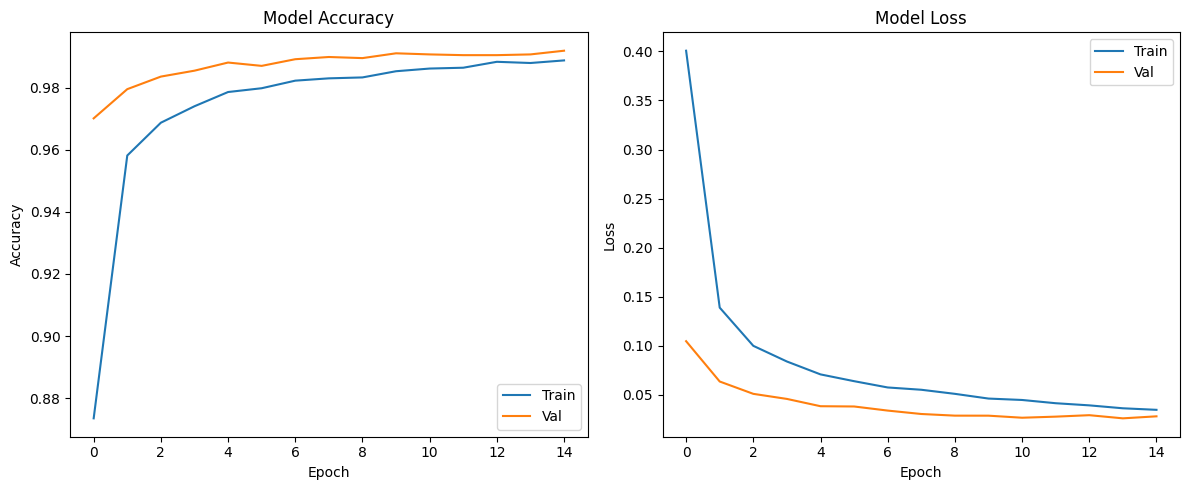

In [5]:
# Plot Training Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


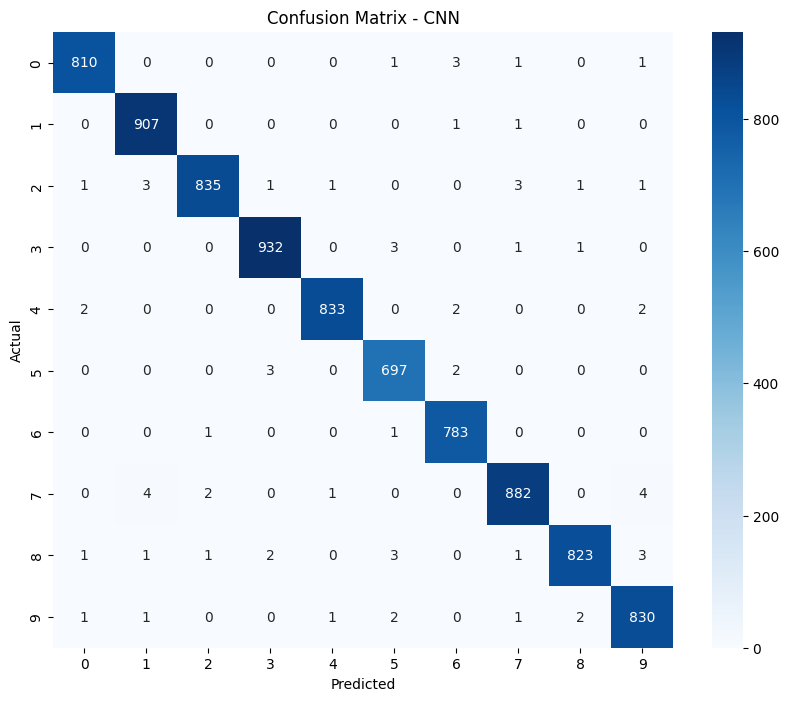

In [6]:
# Evaluate on Validation Set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

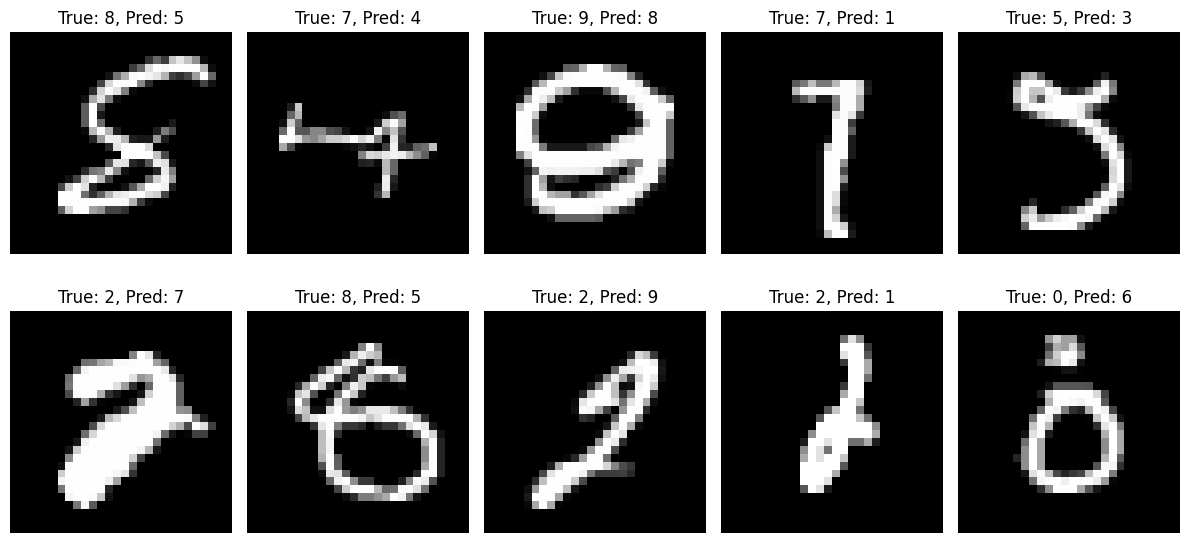

In [7]:
# Misclassified Examples
misclassified = np.where(y_val_pred_classes != y_val_true_classes)[0]
plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_val[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_val_true_classes[idx]}, Pred: {y_val_pred_classes[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Predict Test Data and Save Submission
test_predictions = model.predict(X_test)
test_pred_classes = np.argmax(test_predictions, axis=1)

submission = pd.DataFrame({
    'ImageId': np.arange(1, len(test_pred_classes) + 1),
    'Label': test_pred_classes
})
submission.to_csv('submission.csv', index=False)
print("CNN submission saved as 'submission.csv'")

875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
CNN submission saved as 'submission.csv'
